<!--
pandoc -f markdown+tex_math_single_backslash --filter=pandoc-crossref --citeproc ImplicitGradientGTN.md -o ImplicitGradientGTN.pdf
-->

# Implicit gradient regularisation of the Gurson-Tvergaard-Needleman constitutive equations

**Thomas Helfer**

> **Objectives**
>
> -   Implement the implicit gradient regularisation of the
>     Gurson-Tvergaard-Needleman constitutive equations introduced by El
>     Ouazani Tuhami et al. ([El Ouazani Tuhami et al.
>     2022](#ref-tuham_two_2022)).
> -   Experience the mesh insensitivity of the simulations on a notched
>     specimen.
> -   Describe the effect of the regularisation length(s) on the results
>     of the simulations.

This tutorial describes a simple implementation in `dolfinx_material` of
an implicit gradient regularisation of the Gurson-Tvergaard-Needleman
constitutive equations.

This model involves three unknowns:

-   the displacement $\vec{u}$.
-   the non local plastic change of volume $\bar{\omega}$.
-   the non local equivalent plastic strain $\bar{\kappa}$.

The proposed implementation uses a staggered approach where the
mechanical problem is solved at a fixed non local variables
$\bar{\omega}$ and $\bar{\kappa}$. The non local variables are then
solved using the internal state variables computed by the mechanical
problem.

A fixed point algorithm is used to loosely ensure a convergence state at
the end of the time step.

## Description of the constitutive equations

### Finite strain framework

The behavior is assumed to be expressed in the logarithmic strain
framework ([Miehe, Apel, and Lambrecht
2002](#ref-miehe_anisotropic_2002)).

In the following, $\underline{\varepsilon}^{\mathrm{to}}$ denotes the
(lagrangian) Hencky strain and $\underline{\sigma}$ denote the dual of
the Hencky strain.

### Split of the strain

The behaviour is described by a standard split of the strain
$\underline{\varepsilon}^{\mathrm{to}}$ in an elastic and a plastic
parts, respectively denoted $\underline{\varepsilon}^{\mathrm{el}}$ and
$\underline{\varepsilon}^{\mathrm{p}}$: <span
id="eq:mfront:porous_plasticity:GTN:strain_split">$$
\underline{\varepsilon}^{\mathrm{to}}=\underline{\varepsilon}^{\mathrm{el}}+\underline{\varepsilon}^{\mathrm{p}}
\qquad(1)$$</span>

### Elasticity

The elasticity is assumed linear and isotropic, i.e. given by the Hooke
law: $$
\underline{\sigma}=\lambda\,{\mathrm{tr}{\left(\underline{\varepsilon}^{\mathrm{el}}\right)}}\,\underline{I}+2\,\mu\,\underline{\varepsilon}^{\mathrm{el}}
$$ where $\lambda$ and $\mu$ are the first and second Lamé parameters.

### Plasticity

The yield surface is chosen as follows ([Tvergaard and Needleman
1984](#ref-tvergaardneedleman1984)): $$
f{\left(\underline{\sigma}\right)}=\sigma_{\star}-R{\left(\kappa\right)}
$$ where:

-   $\sigma_{\mathrm{eq}}^{\star}$ is the equivalent stress defined as
    follows: <span id="eq:mfront:porous_plasticity:GTN:S">$$
    S = {\left(\dfrac{\sigma_{\mathrm{eq}}}{\sigma_{\star}} \right)}^2 + 2 q_1 f_{\star} \cosh{{\left(\dfrac{3}{2} q_2 \dfrac{\sigma_m}{\sigma_{\star}}    \right)}} - 1 - q_3 f_{\star}^2  = 0
    \qquad(2)$$</span> which defines implicitly $\sigma_{\star}$, where
    $\sigma_{\mathrm{eq}}$ is the von Mises equivalent stress, and
    $\sigma_m$ the mean stress.
-   $\kappa$ is the equivalent plastic strain.
-   The effective $f_{\star}$ is defined such that: $$
      f_{\star} = \left\{
      \begin{array}{ll}
      \delta f & \mbox{if } f < f_c \\
      f_c + \delta (f - f_c)  & \mbox{otherwise}
      \end{array}
      \right.
    $$ and: $$
    \delta = \left\{
    \begin{array}{ll}
    1 & \mbox{if } f < f_c \\
    \dfrac{f_u- f_c }{f_r - f_c}   & \mbox{otherwise}
    \end{array}
    \right.
    $$ where $f_{u}$ is the root of $2\,q_1\,f-1-q_3\,f^{2}$.

The plastic strain rate $\underline{\varepsilon}^{\mathrm{p}}$ is given
by: <span id="eq:mfront:porous_plasticity:GTN:n">$$
\underline{\dot{\varepsilon}}^{\mathrm{p}}= \dot{\lambda}\, {\displaystyle \frac{\displaystyle \partial \sigma_{\star}}{\displaystyle \partial \underline{\sigma}}} = (1 - f)\, \dot{\kappa}\, {\displaystyle \frac{\displaystyle \partial \sigma_{\star}}{\displaystyle \partial \underline{\sigma}}}
\qquad(3)$$</span> where $f$ is the porosity, $\dot{\lambda}$ is the
plastic multiplier. Here, $\kappa$ can be identified to the equivalent
plastic strain in the matrix.

The rate of the change of the volume induced by the plastic flow is
given by: $$
\dot{\omega} = {\mathrm{tr}{\left(\underline{\dot{\varepsilon}}^{\mathrm{p}}\right)}}
$$

### Evolution of the porosity

Compared to the standard Gurson-Tvergaard-Needleman, the evolution of
the porosity is assumed to be driven by two non local variables
$\dot{\bar{\omega}}$ and $\dot{\bar{\kappa}}$ associated respectively
with the rate of the change of the volume induced by the plastic flow
and the equivalent plastic strain $\dot{\kappa}$

$\bar{\omega}$ and $\bar{\kappa}$ are defined by the following Helmoltz
equations: <span id="eq:Helmoltz">$$
\left\{
\begin{aligned}
-l_{c}^{2}\,\nabla^{2}\bar{\omega}+\bar{\omega} &= \omega \\
-l_{c}^{2}\,\nabla^{2}\bar{\kappa}+\bar{\kappa} &= \kappa
\end{aligned}
\right.
\qquad(4)$$</span>

Compared to the work of El Ouazani Tuhami et al. ([El Ouazani Tuhami et
al. 2022](#ref-tuham_two_2022)), the following differences can be
highlighted:

-   The Helmoltz equations are expressed in the reference
    configurations.
-   For the sake of simplicity, the length scales $l_{c}$ is the same
    for the two variables $\bar{\omega}$ and $\bar{\kappa}$.

> **Note**
>
> For technical reasons related to how external state variables are
> currently handled by the `dolphinx_materials` package, Equations (4)
> are replaced by: <span id="eq:Helmoltz2">$$
> \left\{
> \begin{aligned}
> -l_{c}^{2}\,\nabla^{2}\Delta\,\bar{\omega}+\Delta\,\bar{\omega} &= \Delta\,\omega \\
> -l_{c}^{2}\,\nabla^{2}\Delta\,\bar{\kappa}+\Delta\,\bar{\kappa} &= \Delta\,\kappa
> \end{aligned}
> \right.
> \qquad(5)$$</span>
>
> where $\Delta\,\bar{\omega}$ and $\Delta\,\bar{\kappa}$ denotes the
> increments over the considered time step of $\bar{\omega}$ and
> $\bar{\kappa}$.

The evolution of the porosity is then given by replacing $\bar{\omega}$
and $\bar{\kappa}$ by their non local counterparts. Hence the evolution
of the nucleation porosity $f_{n}$ and growth porosity $f_{g}$ is given
by: $$
\left\{
\begin{aligned}
\dot{f_{n}}&=A_{n}{\left(\bar{\kappa}\right)}\,\dot{\bar{\kappa}} \\
\dot{f_{g}}&={\left(1-f_{g}\right)}\,{\left(\dot{\bar{\omega}}\right)}
\end{aligned}
\right.
$$

In the previous equation, $A_{n}{\left(\bar{\kappa}\right)}$ is given by
the Chu-Needleman model ([Chu and Needleman
1980](#ref-chuneedleman1980)): $$
A_n{\left(\bar{\kappa}\right)} = \dfrac{f_N}{s_N \sqrt{2\pi}} \exp{{\left(-\dfrac{1}{2} {\left(\dfrac{\bar{\kappa} - \epsilon_N}{s_N} \right)}^2  \right)}     }
$$ where $\{f_N,s_N,\epsilon_N\}$ are material parameters.

## Description of the implementation of the mechanical behaviour

The role of the local behaviour is then to describe the evolution of the
elastic strain $\underline{\varepsilon}^{\mathrm{el}}$ and the evolution
of the equivalent plastic strain $\kappa$.

An implicit scheme is used which aims at determining the increments
$\Delta\,\underline{\varepsilon}^{\mathrm{el}}$ and $\Delta\,\kappa$ by
introducing a (generally non linear) system of equations such that: $$
F{\left(\Delta\,\underline{\varepsilon}^{\mathrm{el}}, \Delta\,\kappa\right)} = 0
$$

This non linear system of equations is solved by a Newton algorithm. For
the sake of simplicity, the jacobian of the system will be determined by
a numerical approximation based on a centered finite difference scheme.

The function $f$, called the residual can be decomposed by blocks as
follows: $$
F{\left(\Delta\,\underline{\varepsilon}^{\mathrm{el}}, \Delta\,\kappa\right)} = 
\left(
\begin{aligned}
f_{\underline{\varepsilon}^{\mathrm{el}}}\\
f_{\kappa}\\
\end{aligned}
\right)
$$

The following paragraph shows how to define
$f_{\underline{\varepsilon}^{\mathrm{el}}}$ and $f_{\kappa}$.

### Residual associated with elastic strain

The residual associated with elastic strain is deduced from Equations
(1) and (3): <span id="eq:mfront:porous_plasticity:GTN:feel">$$
f_{\underline{\varepsilon}^{\mathrm{el}}} = \Delta\,\underline{\varepsilon}^{\mathrm{el}}+ {\left(1 - {\left.f\right|_{t+\theta\,\Delta\,t}}\right)}\, \Delta\, \kappa\, {\left.\underline{n}\right|_{t+\theta\,\Delta\,t}}-\Delta\,\underline{\varepsilon}^{\mathrm{to}}
\qquad(6)$$</span> with
$\underline{n}={\displaystyle \frac{\displaystyle \partial \sigma_{\star}}{\displaystyle \partial \underline{\sigma}}}$

### Residual associated with equivalent plastic strain

Assuming that plastic flow occurs, the residual associated with
equivalent plastic strain is meant to ensure that the material is on the
yield surface at the middle of the time step, at $t+\theta\,\Delta\,t$:
<span id="eq:mfront:porous_plasticity:GTN:fkappa">$$
f_{\kappa} = {{\displaystyle \frac{\displaystyle 1}{\displaystyle E}}}{\left({\left.\sigma_{\star}\right|_{t+\theta\,\Delta\,t}}-R{\left({\left.\kappa\right|_{t+\theta\,\Delta\,t}}\right)}\right)}
\qquad(7)$$</span>

The residual is in this case normalized by the Young Modulus $E$ to
ensure that the residual is of the same order of magnitude than
$f_{\underline{\varepsilon}^{\mathrm{el}}}$.

If no plastic flow occurs, $f_{\kappa}$ is simply equal to the increment
of the equivalent plastic strain $\Delta\,\kappa$, which ensures that at
the the convergence of the Newton-Algorithm, the material lies on the
yield surface.

To determine if a plastic flow occurs, one may simply make an estimate
of $\sigma_{\star}$ for a elastic loading for which the elastic strain a
the end of the time step would be
${\left.\underline{\varepsilon}^{\mathrm{el}}\right|_{t}}+\Delta\,\underline{\varepsilon}^{\mathrm{to}}$

## Implementation in `MFront`

The implicit DSL in `MFront` is described on [this
page](https://thelfer.github.io/tfel/web/implicit-dsl.html).

<figure>
<img src="img/ImplicitDSL.svg" id="fig:mfront:implicit-dsl:resolution_steps" style="width:100.0%" alt="Figure 1: Description of the steps of the implicit scheme and the associated code blocks." /><figcaption aria-hidden="true">Figure 1: Description of the steps of the implicit scheme and the associated code blocks.</figcaption>
</figure>

Figure 1 shows the various steps involved during the behaviour
integration with an implicit scheme in `MFront`. In this tutorial, the
following steps are considered:

-   `@InitLocalVariables`, which computes before starting the Newton
    algorithm the evolution of the porosity due to non local variables
    and which computes an elastic prediction to determine if a plastic
    flow occurs.
-   `@Integrator` which aims at computing
    $f_{\underline{\varepsilon}^{\mathrm{el}}}$ and $f_{\kappa}$.
-   `@UpdateAuxiliaryStateVariables` which is called after the
    convergence of the Newton algorithm, to save the values of
    $\Delta\,w$ and $\Delta\,\kappa$ for the determination of
    $\bar{\omega}$ and $\bar{\kappa}$.

The proposed implementation uses the [`StandardElasticity`
brick](https://thelfer.github.io/tfel/web/HookeStressPotential.html)
which:

-   provides a method named `computeElasticPrediction` which computes
    the stress tensor assuming an elastic loading.
-   provides an implementation of the `@ComputeStress` block, which
    computes the stress
    ${\left.\underline{\sigma}\right|_{t+\theta\,\Delta\,t}}$ before
    each evaluation of the residual, i.e. each call to the `@Integrator`
    block.
-   automatically computes the consistent tangent operator
    ${\displaystyle \frac{\displaystyle \partial {\left.\underline{\sigma}\right|_{t+\Delta\,t}}}{\displaystyle \partial \Delta\,\underline{\varepsilon}^{\mathrm{to}}}}$,
    i.e. provides a default implementation of the `@TangentOperator`
    block.

### Computation of the Gurson-Tvergaard-Needleman equivalent stress and its derivatives

The computation of the Gurson-Tvergaard-Needleman equivalent stress and
its derivatives is implemented in the `TFEL/Material` library. The
following functions are declared in the
`GursonTvergaardNeedleman1982StressCriterion.hxx` header:

-   `computeGursonTvergaardNeedleman1982Stress`, which computes
    $\sigma_{\star}$.
-   `computeGursonTvergaardNeedleman1982Normal`, which computes
    $\sigma_{\star}$,
    ${\displaystyle \frac{\displaystyle \partial \sigma_{\star}}{\displaystyle \partial \underline{\sigma}}}$
    and
    ${\displaystyle \frac{\displaystyle \partial \sigma_{\star}}{\displaystyle \partial f}}$.
-   `computeGursonTvergaardNeedleman1982SecondDerivative`, which
    computes $\sigma_{\star}$,
    ${\displaystyle \frac{\displaystyle \partial \sigma_{\star}}{\displaystyle \partial \underline{\sigma}}}$,
    ${\displaystyle \frac{\displaystyle \partial \sigma_{\star}}{\displaystyle \partial f}}$,
    ${{\displaystyle \frac{\displaystyle \partial^{2}\sigma_{\star}}{\displaystyle \partial \underline{\sigma}\partial \underline{\sigma}}}}$
    and
    ${{\displaystyle \frac{\displaystyle \partial^{2}\sigma_{\star}}{\displaystyle \partial \underline{\sigma}\partial f}}}$.
    This function is only usefull if the jacobian of the implicit system
    is computed analytically.

Those functions are used internally by the
[`StandardElastoViscoPlasticity`
brick](https://thelfer.github.io/tfel/web/StandardElastoViscoPlasticityBrick-PorousPlasticity.html).

### Question 1: Implementation of the `@InitLocalVariables` block

Open the `ImplicitGradientGTN.mfront` class and implement:

1.  The evolution of the nucleation and the growth porosities from the
    **increments** of the non local variables $\Delta\,\bar{\omega}$ and
    $\Delta\,\bar{\kappa}$.
2.  The elastic prediction in the `@InitLocalVariables` block to
    determine if a plastic flow occurs assuming a Voce hardening law: $$
    R{\left(\kappa\right)} = R_{0}+{\left(R_{\infty}-R_{0}\right)} \,{\left(1-\exp{\left(-b\,\kappa\right)}\right)}
    $$

### Question 2: Implementation of the `@Integrator` block

Implement the computation of the residual
$f_{\underline{\varepsilon}^{\mathrm{el}}}$ and $f_{\kappa}$ when a
plastic flow occurs using Equations (6) and (7).

### Question 3: Implementation of the `@UpdateAuxiliaryStateVariables` block

Implement the `@UpdateAuxiliaryStateVariables` block.

### Question 4: Simulation of a notched bar

1.  Compile the mfront behaviour:

    ``` bash
    $ mfront --obuild --interface=generic ImplicitGradientGTN.mfront
    ```

2.  Run the simulation given in the `gurson_notched.py` file.

    ``` bash
    $ python3 gurson_notched.py
    ```

3.  Show that the results are not sensitive to the mesh size by
    modifying the `fine_size` parameter. Keep a mesh size consistent
    with the characteristic length $l_c=400\,\mu m$

4.  Observe the influence of the caracteristic length $l_{c}$ for the
    values $350\,\mu m$, $450\,\mu m$ and $600\,\mu m$.

### Question 5: Simulation of a notched bar for the X100 material

Modify the implementation of the `MFront` behaviour and the simulation
script to match the data obtained in TP5.

First, modify the behaviour to use the following hardening law: $$
R{\left(\kappa\right)} = R_{0}^{1}+{\left(R_{\infty}^{1}-R_{0}^{1}\right)}\,{\left(1-\exp(-b^{1}\,\kappa)\right)}+R_{\infty}^{2}\,{\left(1-\exp(-b^{2}\,\kappa)\right)}
$$ with:

-   $R_{0}^{1} = 500$
-   $R_{\infty}^{1} = 750$
-   $b^{1} = 34$
-   $R_{\infty}^{2} = 127$
-   $b^{1} = 500$

Then modify the parameters of the Gurson-Tvergaard-Needleman behaviour
as follows:

-   $f_c=5\,10^{-2}$
-   $f_r=10^{-1}$

The initial porosity must be choosen egal $2\,10^{-4}$.

## References

Chu, C. C., and A. Needleman. 1980. “Void Nucleation Effects in
Biaxially Stretched Sheets.” *Journal of Engineering Materials and
Technology* 102 (3): 249–56.

El Ouazani Tuhami, Amar, Sylvia Feld-Payet, Stéphane Quilici, Nikolay
Osipov, and Jacques Besson. 2022. “A Two Characteristic Length Nonlocal
GTN Model: Application to Cup-Cone and Slant Fracture.” *Mechanics of
Materials* 171: 104350. <https://doi.org/10.1016/j.mechmat.2022.104350>.

Miehe, C., N. Apel, and M. Lambrecht. 2002. “Anisotropic Additive
Plasticity in the Logarithmic Strain Space: Modular Kinematic
Formulation and Implementation Based on Incremental Minimization
Principles for Standard Materials.” *Computer Methods in Applied
Mechanics and Engineering* 191 (47–48): 5383–5425.
<https://doi.org/10.1016/S0045-7825(02)00438-3>.

Tvergaard, V., and A. Needleman. 1984. “Analysis of the Cup-Cone
Fracture in a Round Tensile Bar.” *Acta. Metall.* 32: 157–69.

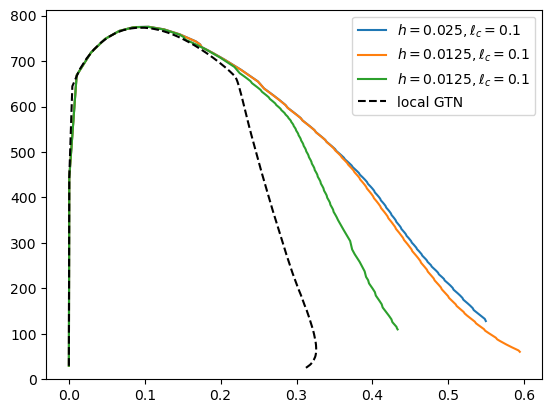

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Load local model results
results = np.loadtxt("results_local.csv", delimiter=",", skiprows=1)
res_local = {"strain": results[:, 0],
            "fmax": results[:, 1],
            "p": results[:, 2],
            "stress": results[:, 3],
            "DeltaPhi": results[:, 4]}

# Load nonlocal model results
def load_data(h, lc):
    results = np.loadtxt(f"nonlocal_mesh_{h}_lc_{lc}/results.csv", 
                         skiprows=1, delimiter=",")
    return {"strain": results[:, 0],
            "fmax": results[:, 1],
            "p": results[:, 2],
            "stress": results[:, 3],
            "DeltaPhi": results[:, 4]}


lc = 0.1
for h in [0.025, 0.0125]:
    res = load_data(h, lc)
    plt.plot(res["DeltaPhi"], res["stress"], '-', label=fr"$h={h}, \ell_c={lc}$")
res = load_data(0.0125, 0.05)
plt.plot(res["DeltaPhi"], res["stress"], '-', label=fr"$h={h}, \ell_c={lc}$")
plt.plot(res_local["DeltaPhi"], res_local["stress"], '--k', label="local GTN")
plt.legend()
plt.ylim(0)
plt.show()